# DLAI Autumn 2019 Project **TEAM 3**
Cai Badal, Gabriel Ferrater, Gerard Gallego & Oriol Sala

**Notebook created for the development of the exercises**


## 0. Project Initialization

### 0.1 Imports

In [0]:
import numpy as np

import copy
import torch
from torch import optim
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

### 0.2 System setup

In [0]:
# Random Seed
torch.manual_seed(1)
np.random.seed(1)

# Select the available device
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
  torch.cuda.manual_seed_all(1)

### 0.3 Data setup

#### 0.3.1 Loading MNIST dataset
We load the Train and Test datasets.

In [3]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.ToTensor())

mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.ToTensor())

0it [00:00, ?it/s]

9920512it [00:02, 3831661.02it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 56618.16it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:01, 962258.17it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 21871.23it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


#### 0.3.2 Train/Validation splits
We split the Train dataset into 95% for training and 5% for validation.

In [0]:
num_train = len(mnist_trainset)
indices = list(range(num_train))
split = int(np.floor(0.05 * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

### 0.4 Functions definition

####0.4.1 Train & Validation

In [0]:
# It helps not crashing when running the notebook the first time
ConvAutoencoder = None
ClassifierTL = None
ConvVarAutoencoder = None

In [0]:
def train_epoch(model, hparams, loader, optimizer, device, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if type(model) == ConvAutoencoder:
            criterion = hparams['criterion']
            loss = criterion(output, data)
        elif type(model) == ClassifierTL:
            criterion = hparams['criterion']
            loss = criterion(output, target)   
        elif type(model) == ConvVarAutoencoder:
            output, mu, logvar = output
            loss = model.criterion(output, data, mu, logvar)
        else:
            raise Exception("You are using a module not implemented yet.")
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % hparams['log_interval'] == 0:
            dataset_len = len(loader) * hparams['batch_size']
            processed_data_len = batch_idx * hparams['batch_size']
            processed_data_len_str = format(processed_data_len, '0'+str(len(str(dataset_len))))
            processed_ratio = round((100. * batch_idx / len(loader)),0)
            loss_str = str(round(loss.item(),6))
            #print(f"Train Epoch: {epoch} [{processed_data_len_str}/{dataset_len} "+\
            #      f"({processed_ratio}%)]\tLoss: {loss_str}")
    return losses

In [0]:
def validate_epoch(model, hparams, loader, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if type(model) == ConvAutoencoder:
                criterion = hparams['criterion']
                loss = criterion(output, data)
            elif type(model) == ClassifierTL:
                criterion = hparams['criterion']
                loss = criterion(output, target)   
            elif type(model) == ConvVarAutoencoder:
                output, mu, logvar = output
                loss = model.criterion(output, data, mu, logvar)
            else:
                raise Exception("You are using a module not implemented yet.")
            losses.append(loss.item())
    
    avg_loss = sum(losses) / len(losses)
    validation_loss_str = str(round(avg_loss,6))
    #print(f"\nValidation:\t\t\t\tLoss: {validation_loss_str} (avg.)\n\n")
    
    return avg_loss

In [0]:
def train(model, hparams, train_loader, valid_loader, optimizer, device):
    train_losses = []
    valid_losses = []
    valid_x = []
    for epoch in range(1, hparams['num_epochs'] + 1):
        epoch_train_losses = train_epoch(model, hparams, train_loader,
                                         optimizer, device, epoch)
        train_losses.extend(epoch_train_losses)
        epoch_valid_loss = validate_epoch(model, hparams, valid_loader, device)
        valid_losses.append(epoch_valid_loss)
        valid_x.append(len(train_losses) - 1)

    train_x = range(len(train_losses))

    return (train_x, train_losses), (valid_x, valid_losses)

####0.4.2 Results

In [0]:
def compute_avg_mse(model, loader):
    avg_mse = []
    for inputs, _ in iter(loader):
        outputs = model(inputs.to(device))
        outputs = outputs.detach().cpu().numpy()
        for input_, output in zip(inputs, outputs):
            mse = (np.square(input_.detach().cpu().numpy() - output)).mean(axis=None)
            avg_mse.append(mse)
    avg_mse = sum(avg_mse) / len(avg_mse)
    return avg_mse

In [0]:
def compute_avg_accuracy(model, loader):
    score = 0
    tests = 0
    for inputs, targets in iter(loader):
      outputs = model(inputs.to(device))
      outputs = outputs.detach().cpu().numpy()
      score += sum(targets.numpy() == np.argmax(outputs, axis=1))
      tests += len(outputs)

    avg_acc = score / tests
    return avg_acc

## 1. **Exercise 1** Convolutional Autoencoder
Train a convolutional autoencoder on MNIST, study the influence of the bottleneck size and generate some images.

### 1.1 Hyperparameters

In [0]:
hparams1 = {
    'num_epochs': 20,
    'batch_size': 256,
    'test_batch_size': 1024,
    'criterion': F.mse_loss,
    'learning_rate': 1e-3,
    'log_interval': 40,
}

### 1.2 Data loaders

In [0]:
train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams1['batch_size'], 
    sampler=train_sampler)
train_iter = iter(train_loader)

valid_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams1['test_batch_size'], 
    sampler=valid_sampler)
valid_iter = iter(valid_loader)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams1['test_batch_size'], 
    shuffle=False)
test_iter = iter(test_loader)

### 1.3 _Convolutional Autoencoder_

#### 1.3.1 Encoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, output_size=20):
        super(Encoder, self).__init__()
        
        self.conv_layer1 = nn.Sequential(  
            nn.Conv2d(1, 6, 5, padding=2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_layer2 = nn.Sequential(  
            nn.Conv2d(6, 16, 5, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.mlp_layer1 = nn.Sequential(   
            nn.Linear(5*5*16, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
        )
        self.mlp_layer2 = nn.Sequential( 
            nn.Linear(200, output_size),
            nn.BatchNorm1d(output_size),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = x.view(-1, 16*5*5)
        x = self.mlp_layer1(x)
        out = self.mlp_layer2(x)
              
        return out

#### 1.3.2 Decoder

In [0]:
class Decoder(nn.Module):
    def __init__(self, input_size=20):
        super(Decoder, self).__init__()

        self.mlp_layer1 = nn.Sequential(
            nn.Linear(input_size, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
        )
        self.mlp_layer2 = nn.Sequential(   
            nn.Linear(200, 400),
            nn.BatchNorm1d(400),
            nn.ReLU()
        )
        self.deconv_layer1 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(16, 6, 5, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
        )
        self.deconv_layer2 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.ConvTranspose2d(6, 1, 5, padding=2),
            nn.BatchNorm2d(1),
            nn.Sigmoid()                
        )

    def forward(self, x):
        x = self.mlp_layer1(x)
        x = self.mlp_layer2(x)
        x = x.view(-1,16,5,5)
        x = self.deconv_layer1(x)
        out = self.deconv_layer2(x)
              
        return out

#### 1.3.3 Autoencoder

In [0]:
class ConvAutoencoder(nn.Module):
    def __init__(self, bottleneck=20):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder(bottleneck)
        self.decoder = Decoder(bottleneck)
    
    def forward(self, x):
        x = self.encoder(x)
        out = self.decoder(x)

        return out

### 1.4 Training

In [0]:
bottlenecks = [1, 2, 6, 10, 16]

In [0]:
models_cae = dict.fromkeys(bottlenecks, None)
tr_losses = dict.fromkeys(bottlenecks, None)
val_losses = dict.fromkeys(bottlenecks, None)

for bn_size in bottlenecks:
    #print('\n'*3, '*'*10, f'Training with bottleneck size: {bn_size}',
    #      '*'*10, '\n')
    models_cae[bn_size] = ConvAutoencoder(bottleneck=bn_size).to(device)
    optimizer = optim.Adam(models_cae[bn_size].parameters(),
                           lr=hparams1['learning_rate'])
    tr_losses[bn_size], val_losses[bn_size] = train(models_cae[bn_size], hparams1,
                                                    train_loader, valid_loader,
                                                    optimizer, device)

### 1.5 Results

#### 1.5.1 Loss curves

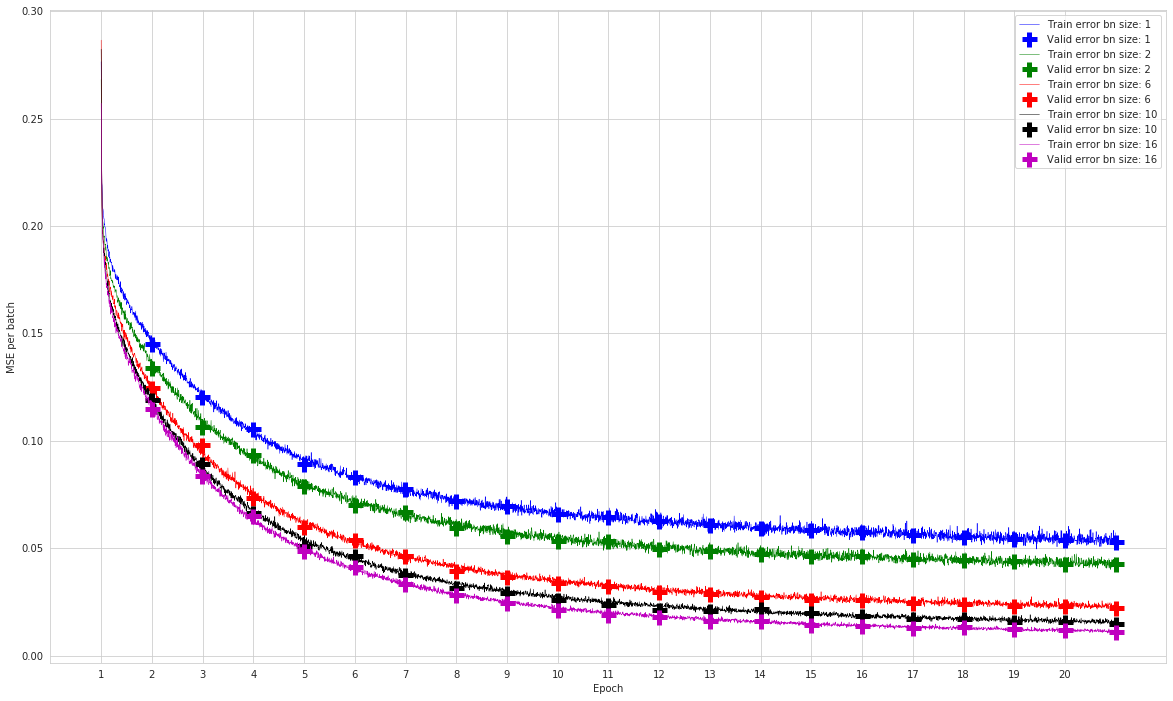

In [18]:
plt.figure(figsize=(20,12))
colors = "bgrkmycw"

for i, bn_size in enumerate(bottlenecks):
    plt.plot(tr_losses[bn_size][0], tr_losses[bn_size][1], '-', color=colors[i],
             lw=0.5, label=f'Train error bn size: {bn_size}')
    plt.plot(val_losses[bn_size][0], val_losses[bn_size][1], '+', color=colors[i],
             ms=15.0, mew=5.0, label=f'Valid error bn size: {bn_size}')

plt.xticks(np.arange(0, max(tr_losses[bn_size][0]),
                     step=max(tr_losses[bn_size][0])/hparams1['num_epochs']), 
                     [i + 1 for i in range(hparams1['num_epochs'])])
plt.xlabel('Epoch')
plt.ylabel('MSE per batch')
plt.grid(True)
plt.legend()
plt.show()

#### 1.5.2 Image reconstruction average error

In [19]:
df_ex1 = pd.DataFrame()
for bn_size, model in models_cae.items():  
    df_ex1.loc[bn_size, 'mse'] = compute_avg_mse(model, valid_loader)
    df_ex1.loc[bn_size, 'trainable_params'] = int(sum(p.numel() for p in models_cae[bn_size].parameters() if p.requires_grad))
    
display(df_ex1)

,mse,trainable_params
1,0.053094,167990.0
2,0.042841,168393.0
6,0.022206,170005.0
10,0.014978,171617.0
16,0.010937,174035.0


#### 1.5.3 Image reconstruction w/ test input & bottleneck size = 16

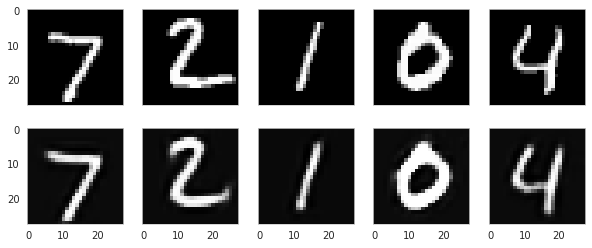

In [20]:
num_images = 5
bottleneck_size = 16
model = models_cae[bottleneck_size]

inputs, targets = test_iter.next()
inputs = inputs[:num_images]
outputs = model(inputs.to(device))
outputs = outputs.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=2, ncols=num_images,
                          sharex=True, sharey=True, figsize=(10,4))
for i in range(num_images):
    axes[0][i].imshow(np.squeeze(inputs[i]), cmap='gray')
    axes[1][i].imshow(np.squeeze(outputs[i]), cmap='gray')

fig.show()

#### 1.5.4 Image reconstruction w/ random latent vector & bottleneck size = 16

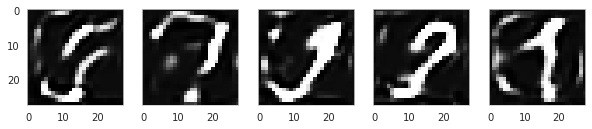

In [21]:
num_images = 5
bottleneck_size = 16
model = models_cae[bottleneck_size]

latent = torch.randn(num_images,bottleneck_size)
outputs = model.decoder(latent.to(device))
outputs = outputs.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=1, ncols=num_images,
                          sharex=True, sharey=True, figsize=(10,4))
for i in range(num_images):
    axes[i].imshow(np.squeeze(outputs[i]), cmap='gray')

fig.show()

## 2. **Exercise 2** Transfer learning
Reuse autoencoder weights for pre-training and fine-tuning of a classifier trained on a small labeled subset of MNIST.

### 2.1 Hyperparameters

In [0]:
hparams2 = {
    'num_epochs': 250,
    'batch_size': 10,
    'test_batch_size': 256,
    'criterion': F.nll_loss,
    'learning_rate': 1e-3,
    'num_classes': 10,
    'log_interval': 2,
}

### 2.2 Data loaders

In [0]:
train100_sampler = SubsetRandomSampler(train_idx[:100])
train100_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams2['batch_size'], 
    sampler=train100_sampler)
train100_iter = iter(train100_loader)

### 2.3 _Classifier_

In [0]:
class ClassifierTL(nn.Module):
    def __init__(self, encoder, hparams):
        super(ClassifierTL, self).__init__()
        self.encoder = encoder
        encoder_out_size = [p for p in self.encoder.parameters()][-1].shape[0]
        self.mlp = nn.Sequential(   
            nn.Linear(encoder_out_size, hparams['num_classes']),
            nn.BatchNorm1d(hparams['num_classes']),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        out = self.mlp(x)
              
        return out

### 2.4 Training

In [0]:
clf_types = ['last_layer', 'finetuning', 'scratch']

models_clf = dict.fromkeys(clf_types, None)
tr_losses = dict.fromkeys(clf_types, None)
val_losses = dict.fromkeys(clf_types, None)

#### 2.4.1 Loading/training Autoencoder

In [0]:
bn_size = 16

try:
    model_cae = models_cae[bn_size]
    
except NameError:
    model_cae = ConvAutoencoder(bottleneck=bn_size).to(device)
    optimizer = optim.Adam(model_cae.parameters(),
                            lr=hparams1['learning_rate'])
    tr_losses, val_losses = train(model_cae, hparams1,
                                  train_loader, valid_loader,
                                  optimizer, device)

#### 2.4.2 Training only last layer
We have freezed the encoding layers trained by the Autoencoder and we have only trained the last classification layer.

In [0]:
convEncoder = copy.deepcopy(model_cae.encoder)
for param in convEncoder.parameters():
    param.requires_grad = False

models_clf['last_layer'] = ClassifierTL(convEncoder, hparams2).to(device)
optimizer = optim.Adam(models_clf['last_layer'].parameters(),
                       lr=hparams2['learning_rate'])
tr_losses['last_layer'], val_losses['last_layer'] = train(models_clf['last_layer'],
                                                          hparams2, train100_loader,
                                                          valid_loader, optimizer,
                                                          device)

#### 2.4.4 Training with fine-tuning
We have trained the whole model but adjusting a learning rate x100 lower for the encoder trained by the Autoencoder.

In [0]:
convEncoder = copy.deepcopy(model_cae.encoder)
models_clf['finetuning'] = ClassifierTL(convEncoder, hparams2).to(device)


optimizer = optim.Adam([{'params': models_clf['finetuning'].encoder.parameters(),
                         'lr': hparams2['learning_rate']/5},
                        {'params': models_clf['finetuning'].mlp.parameters(),
                         'lr': hparams2['learning_rate']}
                        ])

tr_losses['finetuning'], val_losses['finetuning'] = train(models_clf['finetuning'],
                                                          hparams2, train100_loader,
                                                          valid_loader, optimizer,
                                                          device)

#### 2.4.5 Training from scratch
We have used the structure of the encoder from the Autoencoder, but we have reinitilized the weights.

In [0]:
model_cae_empty = ConvAutoencoder(bottleneck=bn_size).to(device)
models_clf['scratch'] = ClassifierTL(model_cae_empty.encoder, hparams2).to(device)
optimizer = optim.Adam(models_clf['scratch'].parameters(),
                       lr=hparams2['learning_rate'])
tr_losses['scratch'], val_losses['scratch'] = train(models_clf['scratch'], hparams2,
                                                    train100_loader, valid_loader,
                                                    optimizer, device)

### 2.5 Results

#### 2.5.1 Loss curves

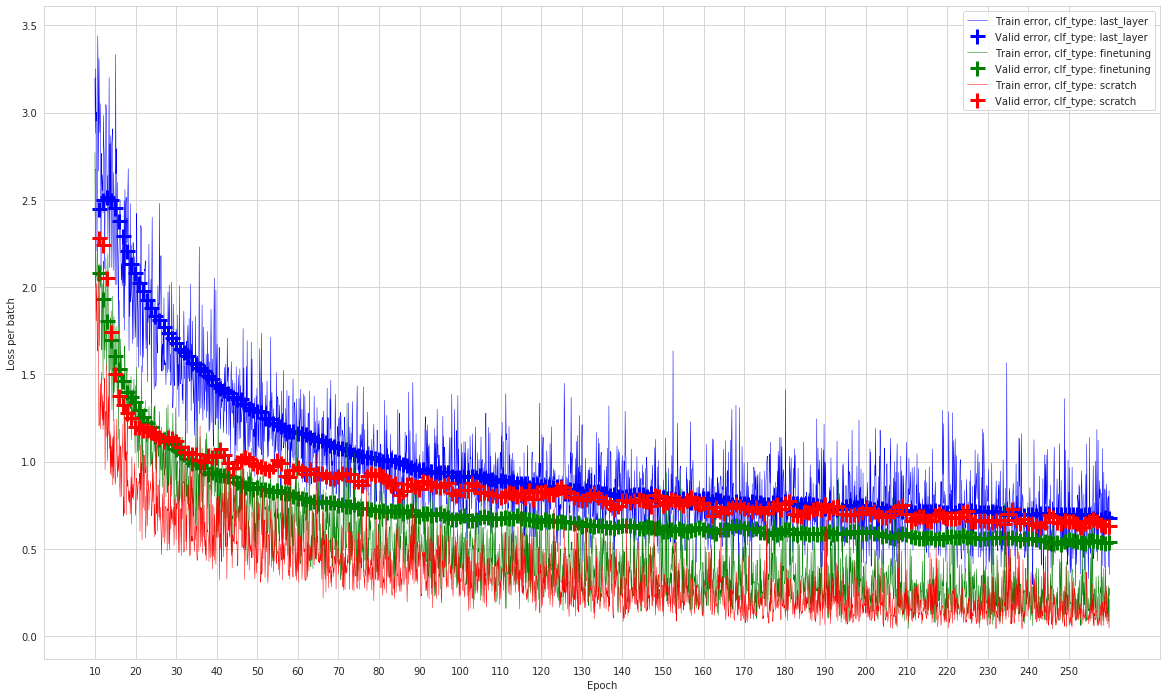

In [30]:
plt.figure(figsize=(20,12))
colors = "bgrkmycw"

for i, clf_type in enumerate(clf_types):
    plt.plot(tr_losses[clf_type][0], tr_losses[clf_type][1],
             '-', lw=0.5, label=f'Train error, clf_type: {clf_type}', color=colors[i])
    plt.plot(val_losses[clf_type][0], val_losses[clf_type][1],
             '+', ms=15.0, mew=3.0, label=f'Valid error, clf_type: {clf_type}', color=colors[i])
plt.xticks(np.arange(0, max(tr_losses[clf_type][0]),
                     step=10*max(tr_losses[clf_type][0])/hparams2['num_epochs']), 
                     [10*(i+1) for i in range(hparams2['num_epochs'])])
plt.xlabel('Epoch')
plt.ylabel('Loss per batch')
plt.grid(True)
plt.legend()
plt.show()

#### 2.5.2 Accuracies

In [31]:
df_ex2 = pd.DataFrame()
for k, model_clf in models_clf.items():  
    df_ex2.loc[k, 'accuracy'] = compute_avg_accuracy(model_clf, test_loader)
    df_ex2.loc[k, 'trainable_params'] = int(sum(p.numel() for p in model_clf.parameters() if p.requires_grad))

display(df_ex2)

,accuracy,trainable_params
last_layer,0.8436,190.0
finetuning,0.8780,86654.0
scratch,0.8587,86654.0


## 3. **Exercise A** Convolutional Variational Autoencoder
Turn the autoencoder from Exercise 1 into a variational autoencoder.

### 3.1 Hyperparameters

In [0]:
hparams3 = {
    'num_epochs': 40,
    'batch_size': 256,
    'test_batch_size': 1024,
    'learning_rate': 1e-3,
    'bottleneck_size': 16,
    'num_z': 15,
    'log_interval': 40,
}

### 3.2 Data loaders

In [0]:
train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams3['batch_size'], 
    sampler=train_sampler)
train_iter = iter(train_loader)

valid_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams3['test_batch_size'], 
    sampler=valid_sampler)
valid_iter = iter(valid_loader)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams3['test_batch_size'], 
    shuffle=False)
test_iter = iter(test_loader)

### 3.3 _Convolutional Variational Autoencoder_

In [0]:
class VarEncoder(Encoder):
    def __init__(self, output_size=20):
        super(VarEncoder, self).__init__(output_size)
        self.mlp_layer21 = copy.deepcopy(self.mlp_layer2)
        self.mlp_layer22 = copy.deepcopy(self.mlp_layer2)
    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = x.view(-1, 16*5*5)
        x = self.mlp_layer1(x)
        mu = self.mlp_layer21(x)
        logvar = self.mlp_layer22(x)

        return mu, logvar

In [0]:
class ConvVarAutoencoder(ConvAutoencoder):
    def __init__(self, bottleneck=20, num_z=10):
        super(ConvVarAutoencoder, self).__init__(bottleneck)
        self.encoder = VarEncoder(bottleneck)
        self.bottleneck = bottleneck
        self.num_z = num_z

    def reparametrize(self, mu, logvar):
        if self.training:
            z = []
            for i in range(self.num_z):
                std = logvar.mul(0.5).exp_()
                eps = Variable(std.data.new(std.size()).normal_())
                z.append(eps.mul(std).add_(mu))
            return z
        else:
            return mu

    def criterion(self, y, x, mu, logvar):
        if self.training:
            BCE = 0
            for y_i in y:
                BCE += F.binary_cross_entropy(y_i, x)
            BCE /= len(y)
        else:
            BCE = F.binary_cross_entropy(y, x)

        # Kullback-Leibler divergence respect to N(0,1)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        KLD /= int(x.view(-1).shape[0])

        return BCE + KLD
  
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        if self.training:
            return [self.decoder(z) for z in z], mu, logvar
        else:
            return self.decoder(z), mu, logvar

        return out, mu, logvar

###3.4 Training

In [0]:
model_cvae = ConvVarAutoencoder(bottleneck=hparams3['bottleneck_size'],
                                num_z=hparams3['num_z']).to(device)
optimizer = optim.Adam(model_cvae.parameters(),
                       lr=hparams3['learning_rate'])
tr_losses, val_losses = train(model_cvae, hparams3,
                              train_loader, valid_loader,
                              optimizer, device)

### 3.5 Results

#### 3.5.1 Loss curves

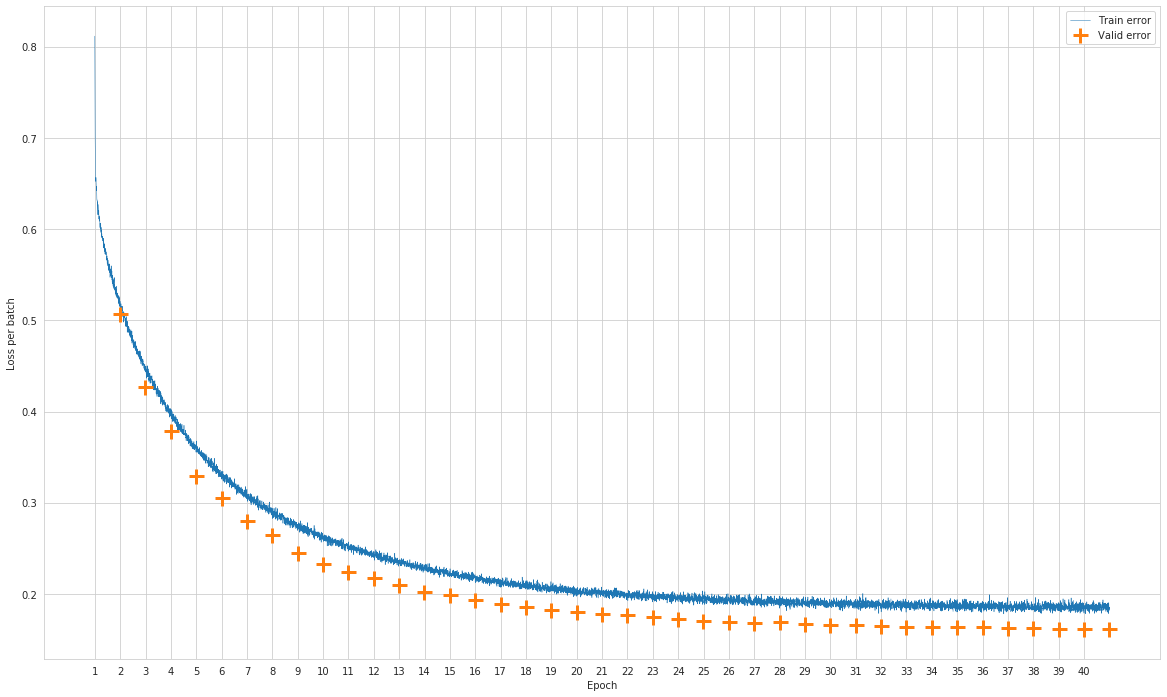

In [37]:
plt.figure(figsize=(20,12))

plt.plot(tr_losses[0], tr_losses[1],
          '-', lw=0.5, label=f'Train error')
plt.plot(val_losses[0], val_losses[1],
          '+', ms=15.0, mew=3.0, label=f'Valid error')

plt.xticks(np.arange(0, max(tr_losses[0]),
                     step=max(tr_losses[0])/hparams3['num_epochs']), 
                     [i + 1 for i in range(hparams3['num_epochs'])])
plt.xlabel('Epoch')
plt.ylabel('Loss per batch')
plt.grid(True)
plt.legend()
plt.show()

#### 3.5.3 Image reconstruction w/ test input & bottleneck size = 16

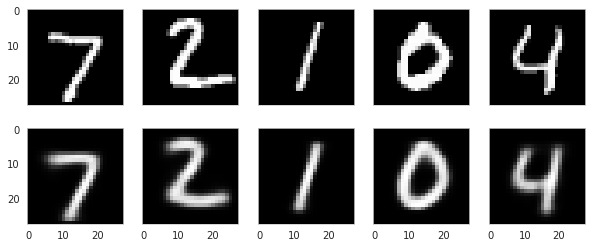

In [38]:
num_images = 5

inputs, targets = test_iter.next()
inputs = inputs[:num_images]
outputs = model_cvae(inputs.to(device))
outputs = outputs[0].detach().cpu().numpy()

fig, axes = plt.subplots(nrows=2, ncols=num_images,
                          sharex=True, sharey=True, figsize=(10,4))
for i in range(num_images):
    axes[0][i].imshow(np.squeeze(inputs[i]), cmap='gray')
    axes[1][i].imshow(np.squeeze(outputs[i]), cmap='gray')

fig.show()

#### 3.5.4 Image reconstruction w/ random latent vector & bottleneck size = 16

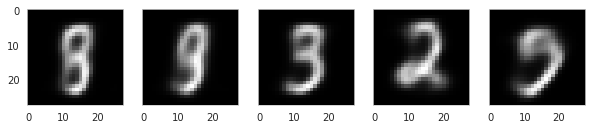

In [48]:
num_images = 5

latent = torch.randn(num_images, hparams3['bottleneck_size'])
outputs = model_cvae.decoder(latent.to(device))
outputs = outputs.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=1, ncols=num_images,
                          sharex=True, sharey=True, figsize=(10,4))
for i in range(num_images):
    axes[i].imshow(np.squeeze(outputs[i]), cmap='gray')

fig.show()